## Lending Club is a "Market Place Lender" which allows an individual to apply for a personal loan to be filled by the market, as opposed to a bank or other specialty lender.   They have grown in success and to date have closed over $3Bn in loans.    Lending Club has made loan and performance information freely available on their website. 

The data is available on the Lending Club website (https://www.lendingclub.com/info/download-data.action).   I manually downloaded the CSV files and stored them locally.   I am using only one subset of the total lending club data.  

My objectives in this project are threefold:
    i) Learn how to view, clean and manipulate large datasets;
    ii)Develop intuition for fitting estimators to the data;
    iii) What are the best predictors of borrower default? 
    iv) What rates do borrowers pay versus their other financial options?
    v) What are the best predictors of early borrower repayment? 
    vi) Start to develop a better way to predict creditworthiness of borrowers beyond the standard methods (eg, FICO); 
        a) For example, can we parse their loan purpose comments to develop a predictor of default?
        b) Can I take location information (eg, via zip codes) to get a better understanding the regional economy? 
        c) Ultimately, I would like to also use complementary external data sources to allow better prediction. 

## This notebook takes a cleaned file created by notebook "Lending Club Cleaning Notebook v2.0" and performs graphing and statistical analysis.   

23JUN 15 - logistic regaression with feature selection implemented.    Graphing ROC function.  Graphing interest rates per lending club classification.   ALmost done with logic to calculate total returns.  

05 Aug - Broke up notebook into three separate notebooks:
     i) File opening, cleaning, and appending;
     ii) Graphs {THIS ONE);
     iii) Stats;
     
The graph and stats notebooks work off the same file created here (currently named Lending_Club_CLEANED_V2.csv).  Some Jiggery Pokery required as LC files from 07-12 have slightly different file structure than later versions.   CUrrently no logic to handle this, as I manually comment/uncomment relevant fields.  
 
05 Sept - Changed some variable names and calculations incorporated into new file structure (Lending_Club_CLEANED_V2.2.csv).   See "Lending Club Cleaning Notebook v2.2.ipyb" for more info. 

In [52]:
# load relevant libraries
# This Workbook assumes the presence of a cleaned Lending Club file.   For more details on cleaning
# And calculated features, see xxx

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from itertools import groupby

%matplotlib inline
# url = "/Users/Glenn/Documents/LendingClub/LendingClub_07-12_CLEANED.csv"
# url = "/Users/Glenn/Documents/LendingClub/LendingClub_12-13_CLEANED.csv"
# url = "/Users/Glenn/Documents/LendingClub/LendingClub_13-14_CLEANED.csv"
# url = "/Users/Glenn/Documents/LendingClub/LendingClub_CLEANED_V2.csv"
# url = "/Users/Glenn/Documents/LendingClub/LendingClub_CLEANED_V2.2.csv"
url = "/Users/Glenn/Documents/LendingClub/LendingClub_CLEANED_V2.3.csv"
lcd = pd.read_csv(url, 
                parse_dates=['last_pymnt_date','issue_date','last_credit_pull_date','next_pymnt_date'])
# lcd=pd.read_csv(url)


In [53]:
# Sort to allow us to groupby and graph results.
lcd.sort(columns = 'time_from_origination_norm', inplace=True)
lcd.reset_index(inplace= True, drop=True)

In [54]:
# Default amount is size of loan if defaulted. 
# Default state should be changed to incorporate different defitions of default.  

default_pct = lcd[lcd['Defaulted']==1].groupby(lcd.clean_term)['loan_amnt'].sum()/lcd.groupby(lcd.clean_term)['loan_amnt'].sum()

In [57]:
# defaulted_df makes a vector of obligors classified as defaulted
# may be more pythonic to use groupby
alpha_grades = ('A','B','C','D','E','F','G')
cum_defaults = pd.DataFrame(columns = alpha_grades)
grade_avg_time_to_default = pd.Series(index=alpha_grades)
# avg_time_to_default = pd.DataFrame(columns= alpha_grades)

for a in alpha_grades:
    # creaate a dataframe which holds only defaulted loans with mos_to_default_norm as the 
    defaulted_df = lcd[(lcd['Defaulted']==1) & (lcd['grade'] == a)][['mos_from_origination_norm','loan_amnt']]

    # calculate total defaults
    defaulted_total = defaulted_df['loan_amnt'].sum()

    # I'm not sure if there's a better way to write the below. 
    defaulted_df.sort(columns = 'mos_from_origination_norm', inplace=True)
    defaulted_df.reset_index(inplace=True,drop=True)

# Got this code from Stack Exchange....very useful!
    cum_defaults[a] = defaulted_df.groupby('mos_from_origination_norm').loan_amnt.sum().cumsum()

    cum_defaults[a] /= defaulted_total

    avg_time_to_default = 0
# take the sum product of mos to default and the defaulted amnt   
    for i in range (0,len(defaulted_df['mos_from_origination_norm'])-1):
        avg_time_to_default += defaulted_df.loc[i,'mos_from_origination_norm']*defaulted_df.loc[i,'loan_amnt'] 
    grade_avg_time_to_default[a] = avg_time_to_default/defaulted_total
   

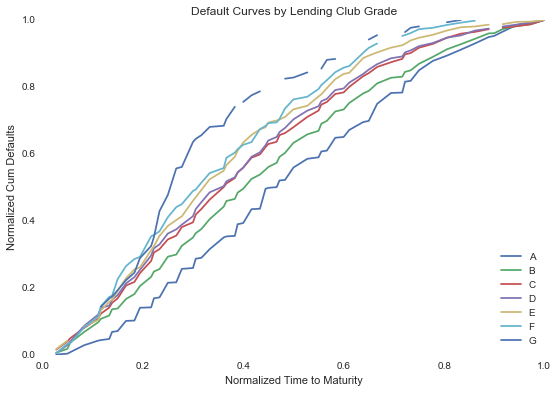

In [58]:
plt.figure(figsize=(9,6))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Normalized Time to Maturity')
plt.ylabel('Normalized Cum Defaults')

plt.title('Default Curves by Lending Club Grade')
for i in alpha_grades:
    plt.plot(cum_defaults.index, cum_defaults[i] ,label= i)
plt.legend(loc=4)
plt.savefig('Default Curve by LC Grade.png', bbox_inches='tight')

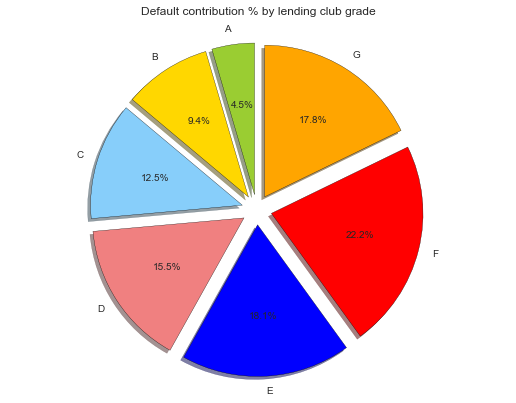

In [59]:
# Plot default pctage by ratings grade

# Select defaulters and total issuance by grade
default_by_grade = lcd[lcd['Defaulted']==1].groupby('grade')['loan_amnt'].sum()
total_issuance_by_grade = lcd.groupby('grade')['loan_amnt'].sum()

# make a df out of these two series
defaults = pd.concat([total_issuance_by_grade,default_by_grade], axis=1)
defaults.columns = ('issuance','defaults')

# Default pctage = total defaults / total issuance 
defaults['cum_default_rate_grade'] = defaults.defaults/defaults.issuance
defaults['grade_pct_of_total']=defaults.cum_default_rate_grade/defaults.cum_default_rate_grade.sum()

defaults.reset_index(inplace=True)

# Pie plotting code from Matplotlib.org 
# plt.subplot(122)
plt.figure(figsize=(9,6))
labels = defaults.grade
sizes = defaults.grade_pct_of_total
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral','blue','red','orange']
explode = (0.1, 0.1, 0.1, 0.1,0.1,0.1,0.1)

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
       autopct='%1.1f%%', shadow=True, startangle=90)

plt.title('Default contribution % by lending club grade \n\n')

# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')

plt.savefig('Default Contributions by Grade.png', bbox_inches='tight')

plt.show()

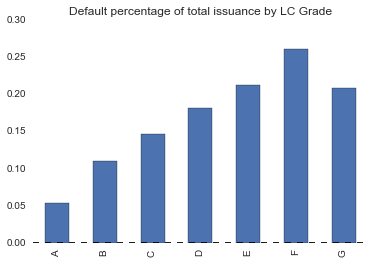

In [60]:
# plt.subplot(111)
defaults['cum_default_rate_grade'].plot(kind='bar',use_index=False, title ='Default percentage of total issuance by LC Grade')
index = np.arange(7)
bar_width = 0.35
# plt.bar(defaults['cum_default_rate_grade'], title ='Default percentage of total issuance by LC Grade')
plt.xticks(index,labels)
plt.savefig('Default percent by Rating.png', bbox_inches='tight')
plt.show()


In [49]:
lcd[(lcd['fico_interp']==612) & (lcd['Defaulted']==1)]['loan_amnt'].sum()/lcd[(lcd['fico_interp']==612) & (lcd['Closed']==1)]['loan_amnt'].sum()

0.0

In [47]:
lcd[(lcd['fico_interp']==667) & (lcd['Closed']==1)]['loan_amnt'].sum()

15310175.0

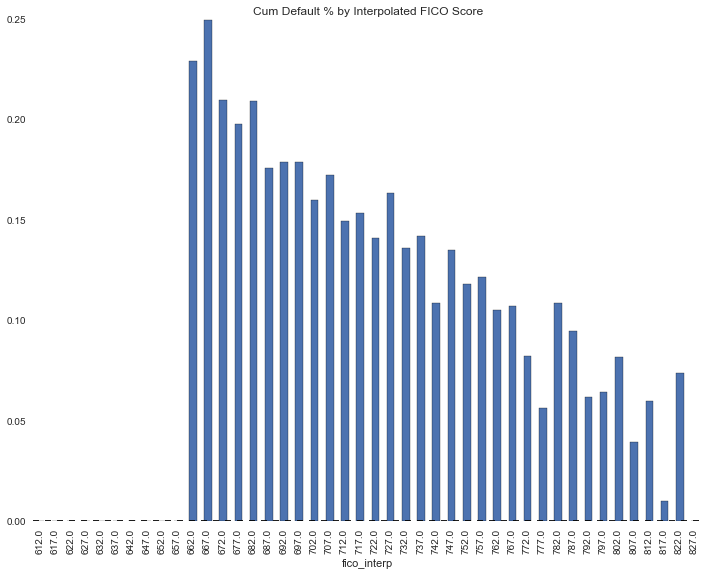

In [61]:
# Graph default rates per bucket by FICO scores...

# fico_graph = lcd.groupby(lcd.fico_interp)['cum_defaults'].sum()/lcd.groupby(lcd.fico_interp)['cum_defaults'].count()

fico_graph = lcd[lcd['Defaulted']==1].groupby(lcd.fico_interp)['loan_amnt'].sum()/lcd[lcd['Closed']==1].groupby(lcd.fico_interp)['loan_amnt'].sum()

fico_graph.plot(figsize=(12,9), kind = 'bar',title = 'Cum Default % by Interpolated FICO Score')

plt.savefig('Default Rate by Fico.png', bbox_inches='tight')

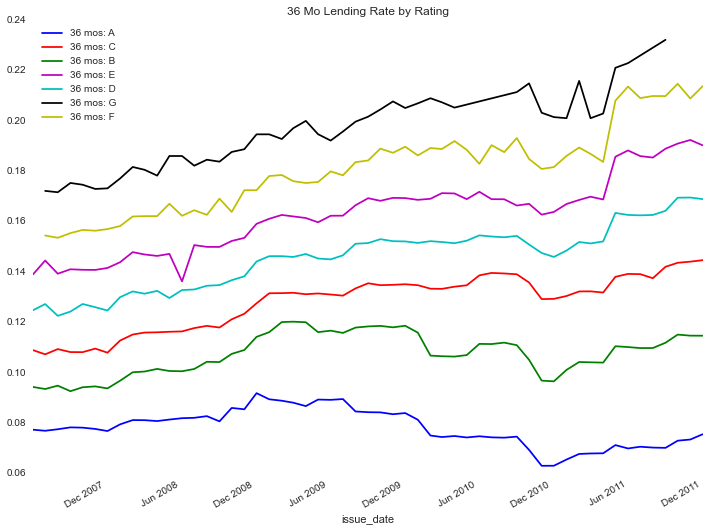

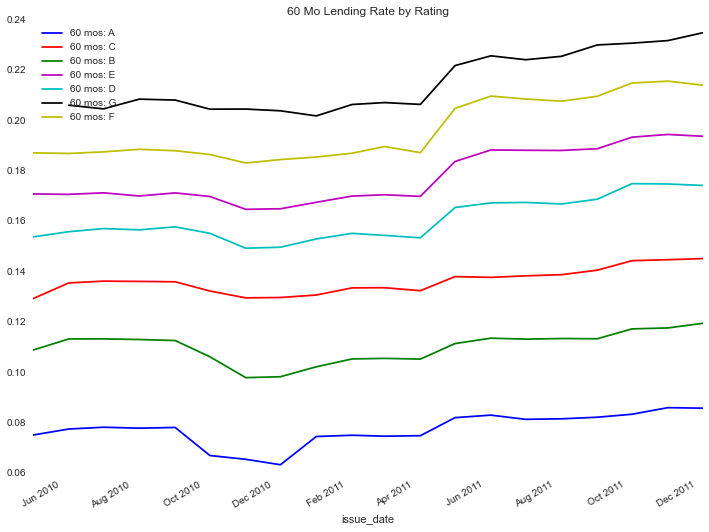

In [74]:
#  This code is from Stackoverflow...quicker and more elegant !
plt.close('all')

# Define colour scheme
color_scheme = {'A':'b','B':'g','C':'r','D':'c','E':'m','F':'y','G':'k'}

# Define two fig windows and corresponding axes...
fig1, ax1 = plt.subplots(figsize=(12,9)) # same as plt.subplots(1, 1)
fig2, ax2 = plt.subplots(figsize=(12,9))

# Assign a set of lines for each term to a different axes and figure...
for term, ax in zip([36,60], [ax1, ax2]):
    ax.hold(True)
    for grade, color in color_scheme.items():
        # Plot line of ROI for each grade to selected axes grouped by issue date
         lcd[(lcd['grade'] == grade) & (lcd['clean_term']==term)].groupby(
            'issue_date')['clean_rate'].mean().plot(color=color_scheme[grade],label = ("%i mos: %s" % (term,grade)),ax=ax)
    ax.legend(loc=2)
    title = ("%i Mo Lending Rate by Rating" % term)
    ax.set_title(title)
    filename = title + '.png'
    plt.savefig(filename, bbox_inches='tight', dpi=100, papertype='letter')
    ax.hold(False)
    # ax.title

fig1.show()
fig2.show()

In [8]:
# Code from Stack Overflow which implements a faster solution than above using np.where and a "mask" boolean 

# severity = .80

# mask = (lcd['Total_Defaults'] == 1)
# mask2 = (lcd['mos_to_default'] > lcd['clean_term'])

# IF Default, total cf is number of years to default * interest rate + (1-severity) * Loan_Amnt
# A = ((((lcd['mos_to_default'] /12) * lcd['clean_rate']) + (1 - severity))*lcd['loan_amnt'])

# Otherwise, its the return to maturity. 
# B = (1+lcd['clean_term']/12 * lcd['clean_rate'])*lcd['loan_amnt']
# C = (1+lcd['mos_to_default']/12 * lcd['clean_rate'])*lcd['loan_amnt']

# D = np.where(mask2,B,C)

# lcd['cum_cf'] = np.where(mask, A, B)

In [9]:
# Calculate annualized ROI for each loan. THis is a rough approximation, but ok for aggregate stuff. 
# mask = (lcd['Total_Defaults'] == 1)

# If default, ROI is calculated to the default term 
# A = (lcd['cum_cf']/lcd['loan_amnt'])**(12/lcd['mos_to_default'])-1

# If no Default, ROI is annualized per the term
# B = (lcd['cum_cf']/lcd['loan_amnt'])**(12/lcd['clean_term'])-1

# lcd['ROI']=np.where(mask, A, B)

In [63]:
lcd['issue_year']= lcd.issue_date.dropna().apply(lambda x: x.strftime('%Y'))

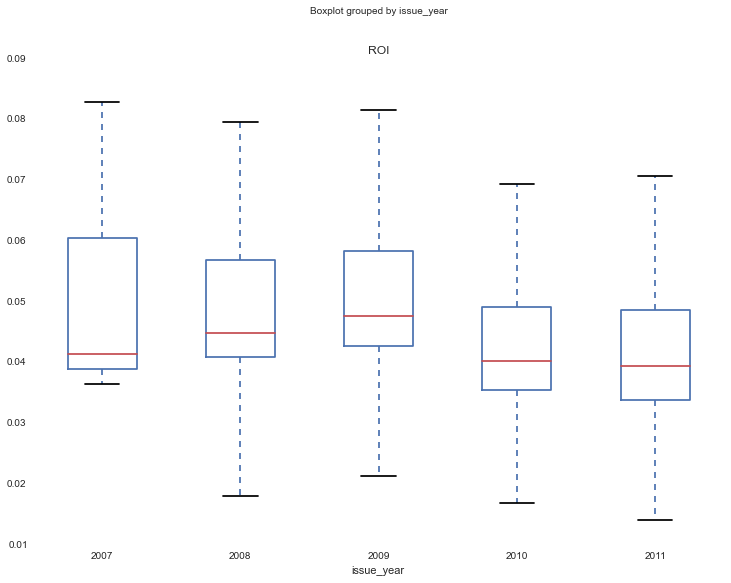

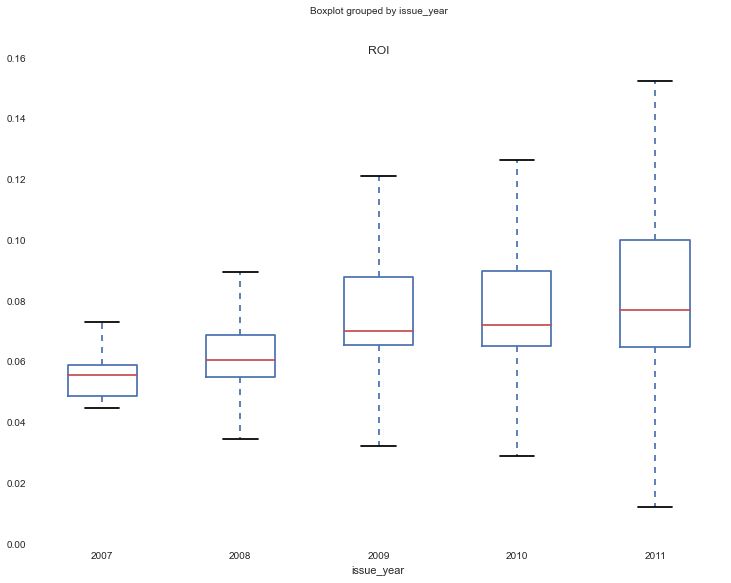

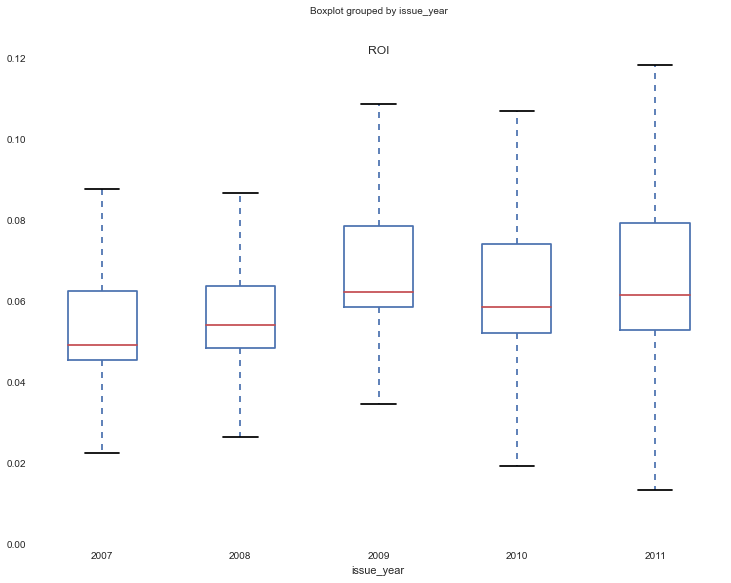

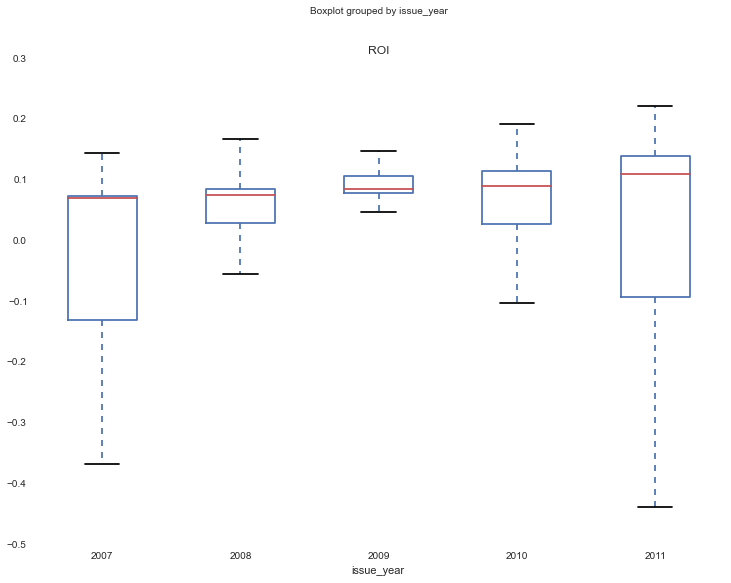

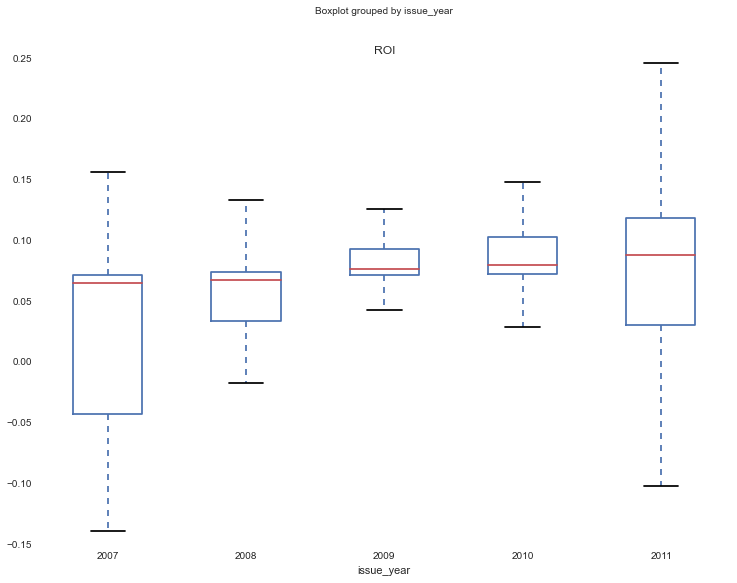

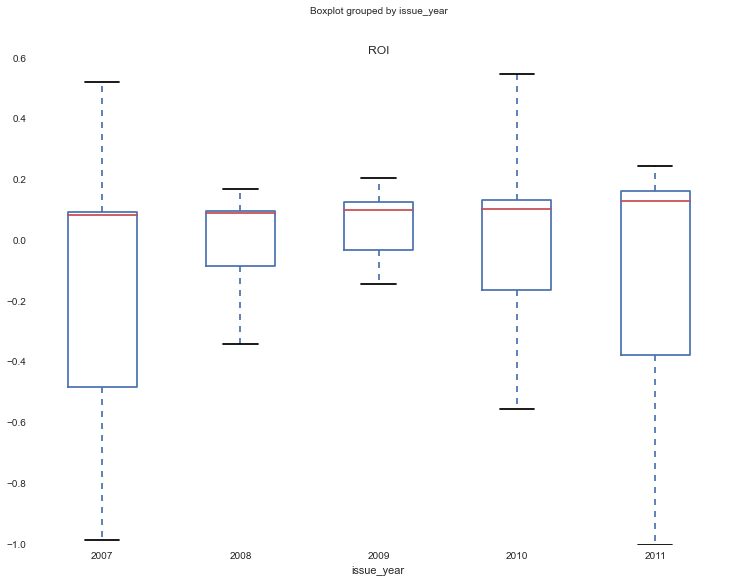

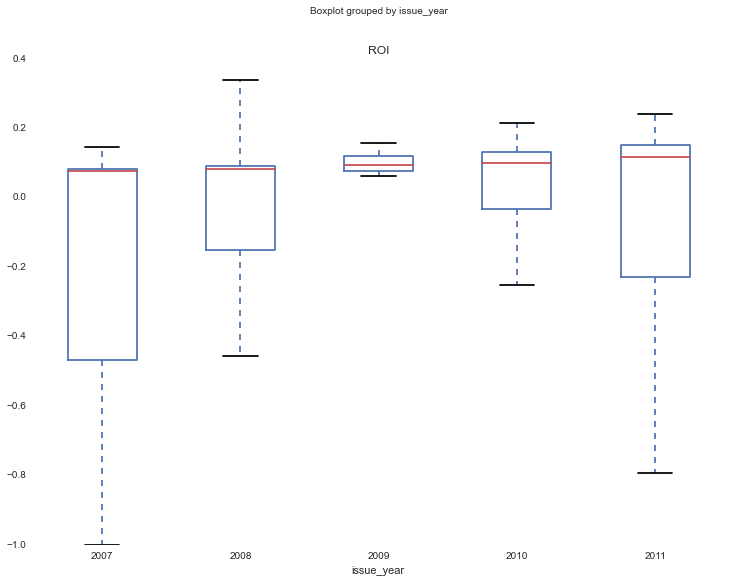

In [64]:
filenames =[]
fig1, ax1 = plt.subplots(figsize=(12,9)) # same as plt.subplots(1, 1)
fig2, ax2 = plt.subplots(figsize=(12,9))
fig3, ax3 = plt.subplots(figsize=(12,9))
fig4, ax4 = plt.subplots(figsize=(12,9))
fig5, ax5 = plt.subplots(figsize=(12,9))
fig6, ax6 = plt.subplots(figsize=(12,9))
fig7, ax7 = plt.subplots(figsize=(12,9))

# for term, ax in zip([36,60], [ax1, ax2]):
for ax, grade in zip([ax1, ax2, ax3, ax4, ax5, ax6, ax7], color_scheme):
    ax.hold(True)
#    for grade in color_scheme:
        # Plot line of ROI for each grade to selected axes grouped by issue date
    lcd[(lcd['Closed']==1) & (lcd['grade'] == grade)].boxplot(column= 'ROI', 
                                    by = 'issue_year',  showfliers = False, ax=ax)
        
    #ax.legend(loc=2)
    title = ("LC_Grade_%s" % grade)
    filenames.append( title + '.png')
    # plt.savefig(filename, bbox_inches='tight', dpi=100, papertype='letter')
    ax.hold(False)
    # ax.title

fig1.show()
fig1.savefig(filenames[0],bbox_inches='tight', dpi=100, papertype='letter')
fig2.show()
fig2.savefig(filenames[1],bbox_inches='tight', dpi=100, papertype='letter')
fig3.show()
fig3.savefig(filenames[2],bbox_inches='tight', dpi=100, papertype='letter')
fig4.show()
fig4.savefig(filenames[3],bbox_inches='tight', dpi=100, papertype='letter')
fig5.show()
fig5.savefig(filenames[4],bbox_inches='tight', dpi=100, papertype='letter')
fig6.show()
fig6.savefig(filenames[5],bbox_inches='tight', dpi=100, papertype='letter')
fig7.show()
fig7.savefig(filenames[6],bbox_inches='tight', dpi=100, papertype='letter')

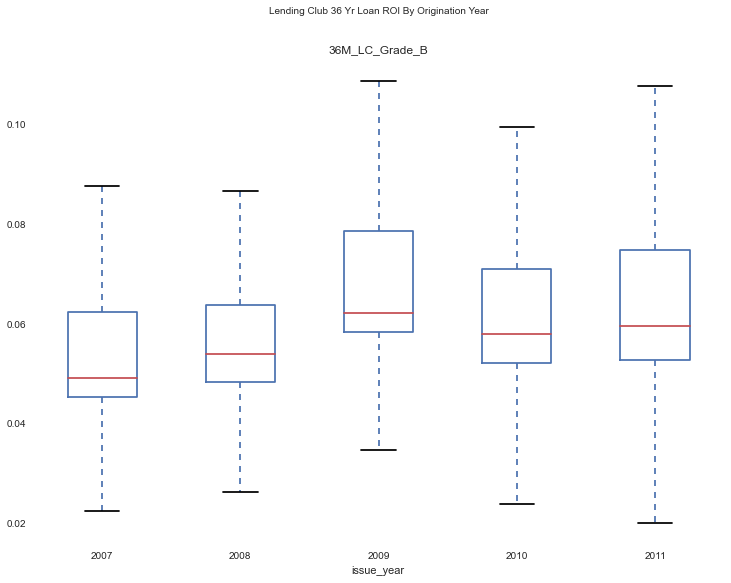

In [65]:
#  Trying to plot just one.   
fig, ax = plt.subplots(figsize= (12,9))
grade = 'B'
term = 36

# Create a df (?) of closed loans with selected term and grades.  
lcd[(lcd['Closed']==1) & (lcd['clean_term']==term) & (lcd['grade'] ==grade)].boxplot(column= 'ROI', 
                                                                    by = 'issue_year',  showfliers = False, ax=ax)

# box - df['ROI'].boxplot(ax=ax)
# bp = df.boxplot(column= 'ROI', by = 'issue_year',  figsize = (12,9), ax=ax)
# yval = np.concatenate([line.get_ydata() for line in bp['whiskers']])
# eps = 1.0
# ymin, ymax = yval.min()-eps, yval.max()+eps
# ax.set_ylim([ymin,ymax])

ax.margins(y=0.05)

plt.suptitle("Lending Club %i Yr Loan ROI By Origination Year" % term)
title = ("%iM_LC_Grade_%s" % (term,grade))
plt.title(title)
# plt.plot()
# ax.set_ylim([ymin,ymax])
plt.show()
# plt.savefig(title, bbox_inches='tight')

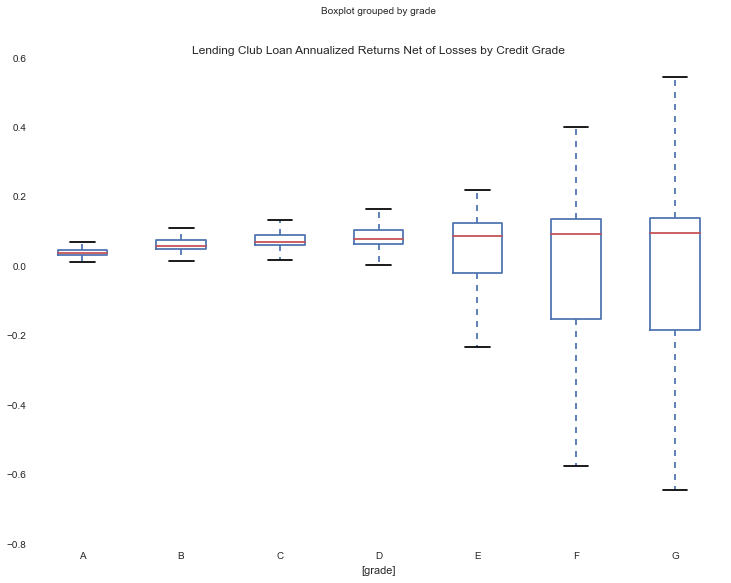

In [67]:
# lcd.plot(column='ROI', by=['grade', 'initial_list_status'], figsize = (12,9))
lcd[lcd['Closed']==1].boxplot(column = 'ROI', by=['grade',], figsize = (12,9),showfliers= False)
# plt.ylim(0.0,0.3)

plt.title("Lending Club Loan Annualized Returns Net of Losses by Credit Grade")

plt.savefig('LC Historical Returns by Rating.png', bbox_inches='tight')

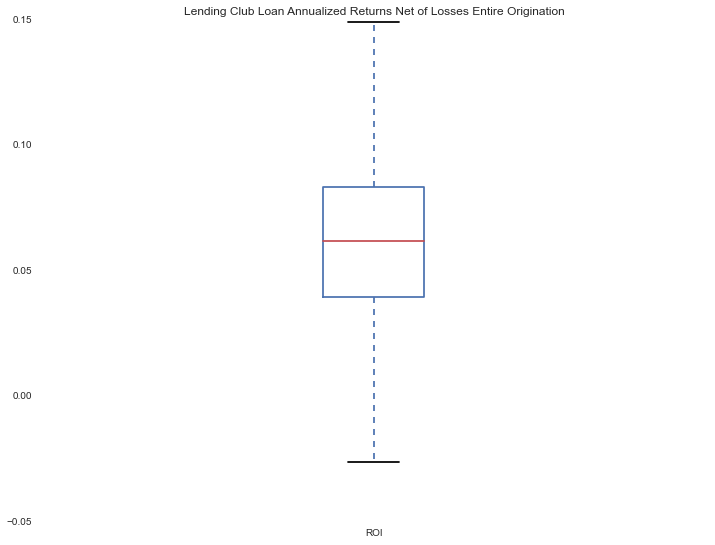

In [70]:
plt.figure(figsize=(12,9))
# plt.ylim(0.0,0.3)

plt.title("Lending Club Loan Annualized Returns Net of Losses Entire Origination")

lcd[lcd['Closed']==1].boxplot(column = 'ROI', figsize = (12,9),showfliers= False)

plt.savefig('LC Historical Returns A.png', bbox_inches='tight')
plt.show()

In [73]:
lcd.initial_list_status.unique()

array(['f'], dtype=object)

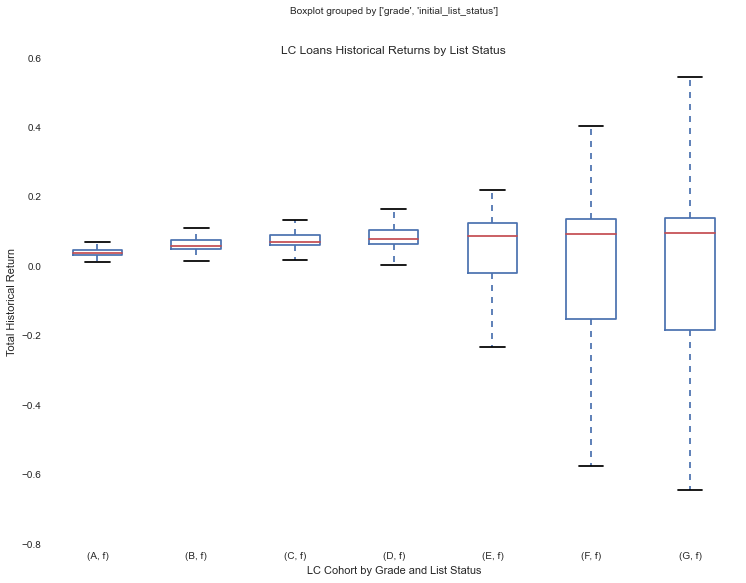

In [72]:
# Plot data sorted by Grade and Intial List Status. 
lcd[lcd['Closed']==1].boxplot(column='ROI', by=['grade', 'initial_list_status'], figsize = (12,9),showfliers = False)
# plt.ylim(0.0,0.25)
plt.title('LC Loans Historical Returns by List Status')
plt.xlabel('LC Cohort by Grade and List Status')
plt.ylabel('Total Historical Return')
plt.savefig('LC Historical Returns by List Status.png', bbox_inches='tight')